## Openturns, contraintes en tant que telles

Matériau composite : 5 couches de bois ; optimisation multi-objectif: on regarde la masse et les déformations de la structure selon x. 

In [1]:
def clear_file(file_path):
    with open(file_path, 'w') as file:
        # Ouvrir en mode écriture 'w' efface le contenu du fichier
        pass 

def trace(file_path):
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and line!='-------' :
                if len(values) == 0:
                    values.append(float(line))
                elif float(line)!=values[len(values)-1]: 
                    values.append(float(line))
    return values


In [2]:
import openturns as ot
import numpy as np
import subprocess
class MyModel2:
    def __init__(self, noms_params, Re, penalty, epaiss, rho):
        self.noms_params = noms_params
        self.Re = Re
        self.penalty = penalty
        self.epaiss = epaiss
        self.rho = rho

    def write_params(self, params):
        list_params = [(self.noms_params[i], params[i]) for i in range(len(params))]
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/ModeleTable_OCTAVE/Param_test.txt'
        with open(filename, 'w') as file:
            for param, value in list_params:
                file.write(f"{param} {value}\n")
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_para_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            for param, value in list_params:
                
                file.write(f"{param} {value}\n")
    def read_defo(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/deformations'
        defo_values = []
        start_reading = False
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if "EPXX" in line:
                    start_reading = True
            
                if start_reading:

                    if '=====>' in line:
                        break
                    try:
                        defo = line.split("|")
                        if len(defo) <=5:
                            break
                        else:
                            defo = defo[4]
                            defo = float(defo)
                            defo_values.append(defo)
                    except ValueError:
                        continue
        return(defo_values)
        
    def read_output(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/res_const.txt'
        vm_values = []
        start_reading = False
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if "VMIS" in line:
                    start_reading = True
            
                if start_reading:

                    if '=====>' in line:
                        break
                    try:
                        vm = line.split("|")
                        if len(vm) <=5:
                            break
                        else:
                            vm = vm[4]
                            vm = float(vm)
                            vm_values.append(vm)
                    except ValueError:
                        continue
        return(vm_values)

    def launch_calcul(self):
        l1 = subprocess.check_output('wsl -d smeca /opt/sm/bin/as_run /mnt/c/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/export')
        return(l1)        

    def launch_mesh(self):
        l1 = subprocess.check_output('wsl -d smeca /opt/sm/bin/salome_meca shell python /mnt/c/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/script_compo2.py')
        return(l1)

    def read_flamb(self):
        with open('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/resu_flamb', 'r') as file:
            lines = file.readlines()

        # Initialiser une liste pour stocker les valeurs de CHAR_CRIT
        char_crit_values = []

        # Parcourir chaque ligne et extraire la valeur de CHAR_CRIT
        for line in lines:
            # Supprimer les espaces en début et fin de ligne
            line = line.strip()
            if "=====>" in line:
                break
            # Vérifier si la ligne contient une valeur CHAR_CRIT valide
            if line and not any(c.isalpha() for c in line.split()[1:]):
                # Extraire la valeur de CHAR_CRIT (colonne 2)
                try:
                    char_crit = line.split()[1].replace('D', 'E')  # Remplacer D par E pour notation scientifique
                    char_crit = float(char_crit)  # Convertir en float
                    char_crit_values.append(char_crit)
                except (IndexError, ValueError):
                # Ignorer les lignes qui ne correspondent pas au format attendu
                    continue

        char_crit_array = np.array(char_crit_values)
        return(char_crit_array)

    def read_mass(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/masse.txt'
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        for line in lines:
            if line.startswith("Table"):
                columns = line.split()
                try:
                    mass = float(columns[2])
                       
                    return mass
                except (IndexError, ValueError) as e:
                    raise ValueError("Erreur lors de l'extraction de la masse : {}".format(e))
         
        raise ValueError("La ligne contenant la masse n'a pas été trouvée.")
    def insert_line_before_clt140(self, params):
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'
        # Lire le contenu du fichier
        with open(filename, 'r') as file:
            lines = file.readlines()
    
        # Trouver l'index de la ligne contenant 'clt140'
        for i, line in enumerate(lines):
            if 'a = ' in line:
                index = i
                break    
        lines[index] =  f'a = {params[len(params)-2]}\n'
        for i, line in enumerate(lines):
            if 'N = ' in line:
                index = i
                break    
        lines[index] =  f'N = {params[len(params)-1]}\n'    
        # Écrire le contenu modifié dans le fichier
        with open(filename, 'w') as file:
            file.writelines(lines)
    
    def remove_section(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'
        with open(file_path, 'r') as file:
            lines = file.readlines()
        start_keyword = 'clt140 = '
        end_keyword = 'fieldmat = '
        new_lines = []
        inside_section = False
        for line in lines:
            if start_keyword in line:
                new_lines.append(line)
                inside_section = True
            if end_keyword in line and inside_section == True:
                inside_section = False
                new_lines.append(line)
                continue
            if inside_section == False:
                new_lines.append(line)
        with open(file_path, 'w') as file:
            file.writelines(new_lines)
    
    def for_couches(self, params):
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'

        with open(filename, 'r' ) as file:
            lines = file.readlines()
        b = True
        to_bewritten = f'''_F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION={params[-2]}),'''
        for i in range (int(params[len(params)-1]-1)):
            if b :
                to_bewritten = to_bewritten + '\n'
                to_bewritten = to_bewritten + f'''                                 _F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION={params[-2]}),'''
                b = False
            else : 
                to_bewritten = to_bewritten + '\n'
                to_bewritten = to_bewritten + '''                                 _F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION=0.0),'''
                b = True
        for k, line in enumerate(lines):
            if 'clt140 = ' in line:
                index = k
                break 
        lines[index] = f'''clt140 = DEFI_COMPOSITE(identifier=\'7:1\', 
                        COUCHE= ({to_bewritten}))\n'''
        with open(filename, 'w') as file:
                file.writelines(lines)
        
    def perform_calculations(self, params):
        self.insert_line_before_clt140(params)
        self.write_params(params)
        self.remove_section()
        self.for_couches(params)
        self.launch_mesh()
        self.launch_calcul()
 
        self.results_vm = self.read_output()
        self.results_flamb = self.read_flamb()
        self.mass = self.read_mass()
        self.defo = self.read_defo()   

    def objective(self, params):
        self.perform_calculations(params)
        alpha = min(np.abs(self.defo))
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            file.write(f"{alpha}\n")
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            file.write(f"{self.mass}\n")
        return self.mass,alpha
    
    def constr_flamb(self, params):
        self.perform_calculations(params)
        coeff = np.abs(self.results_flamb)

        return(min(coeff)-1)
    
    def constr_vm(self, params):
        self.perform_calculations(params)
        coeff = np.abs(self.results_vm)
        return(-max(coeff)+Re)

In [4]:
# Créer une instance du modèle
noms_params = ['L1', 'L2', 'H', 'P', 'a', 'N']
Re = 80
penalty = 10e6
epaiss = 20
rho = 7800

model = MyModel2(noms_params, Re, penalty, epaiss, rho)

# Définir la fonction objectif pour OpenTURNS
def objective_function(params):
    return [model.objective(params)[0], model.objective(params)[1]]


def constraint_flamb(params):
    return([model.constr_flamb(params)])

def constraint_vm(params):
    return([model.constr_vm(params)])

integer_values = [[i] for i in range (1,20)]
discrete_values = ot.Sample(integer_values)
factory = ot.UserDefinedFactory()
distribution = factory.build(discrete_values)

# Créer un problème d'optimisation
problem2 = ot.OptimizationProblem(ot.PythonFunction(len(noms_params), 2, objective_function))
problem2.setMinimization(True)
bounds = ot.Interval([500,300,400,25,0,1],[3000, 2000, 1500, 100, 90,20])
problem2.setBounds(bounds)
problem2.setInequalityConstraint(ot.PythonFunction(len(noms_params), 1, constraint_flamb) )
problem2.setInequalityConstraint(ot.PythonFunction(len(noms_params), 1, constraint_vm) )
problem2.setVariablesType([ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.INTEGER])

In [13]:
uniform = ot.ComposedDistribution([ot.Uniform(500, 3000), ot.Uniform(300, 2000), ot.Uniform(400, 1500), ot.Uniform(25,100), ot.Uniform(0,90), distribution])

ot.RandomGenerator.SetSeed(0)

init_pop = uniform.getSample(8)

In [6]:
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_para_compo.txt'
clear_file(file_path)
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt'
clear_file(file_path)
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt'
clear_file(file_path)

algo = ot.Pagmo(problem2, 'nsga2', init_pop) 

algo.setMaximumIterationNumber(10) 

algo.run() 

result = algo.getResult() 

final_pop_x = result.getFinalPoints() 

final_pop_y = result.getFinalValues() 

In [7]:
front0 = result.getParetoFrontsIndices()[0] 

front0_x = final_pop_x.select(front0) 

front0_y = final_pop_y.select(front0) 

In [8]:
front0_x

,v0,v1,v2,v3,v4,v5
0,622.7929,445.8345,1117.275,95.26365,15.22949,13
1,658.0152,383.616,1121.575,95.26142,15.22953,13
2,622.7929,445.8345,1117.275,95.26365,15.22949,13


In [9]:
front0_y

,v0,v1
0,1.02752e+11,3.269793e-10
1,1.00752e+11,1.470709e-09
2,1.02752e+11,3.269793e-10


Text(0, 0.5, 'Valeur')

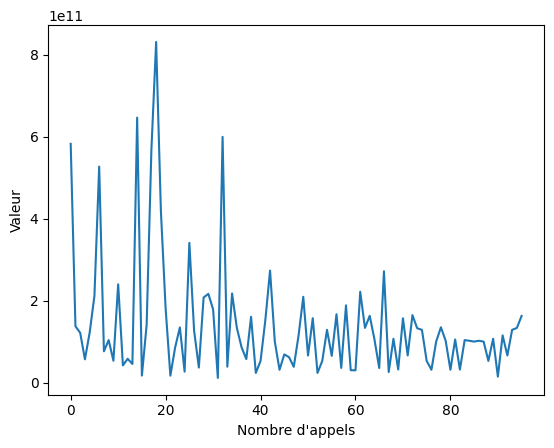

In [10]:
import matplotlib.pyplot as plt

Mass_tab = trace('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt')

plt.plot(Mass_tab)
plt.xlabel('Nombre d\'appels')
plt.ylabel('Valeur')

Text(0, 0.5, 'Valeur')

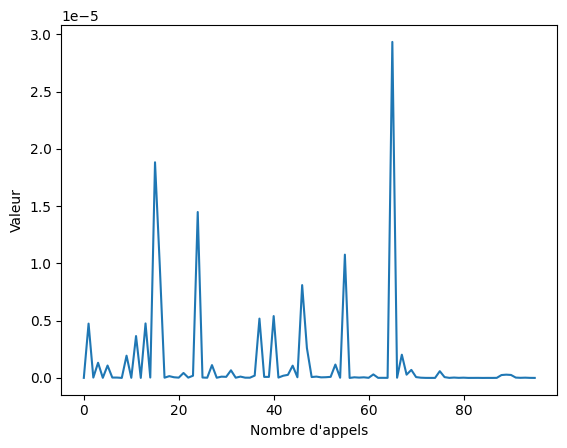

In [11]:
import matplotlib.pyplot as plt

defo_tab = trace('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt')

defo_tab = [defo_tab[2*i] for i in range (len(defo_tab)//2)]
plt.plot(defo_tab)
plt.xlabel('Nombre d\'appels')
plt.ylabel('Valeur')

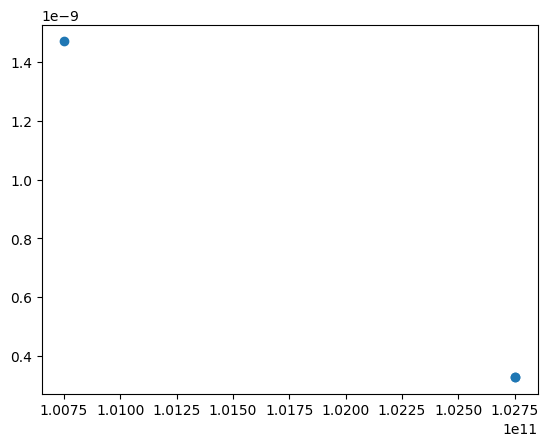

In [12]:
plt.scatter(front0_y[:,0], front0_y[:,1])